# 导入库包配置GPU

In [1]:
# # Statistics tools
# from scipy import stats
# from scipy.stats import skew,norm
# from scipy.special import boxcox1p
# from scipy.stats import boxcox_normmax
# import scipy.stats as stats

# Visualizing tools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as ppf
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# # 设置中文和'-'负号显示问题
# from pylab import mpl
# mpl.rcParams['font.sans-serif'] = ['FangSong']  # 设置matplotlib可以显示汉语
# mpl.rcParams['axes.unicode_minus'] = True

# Preprocessing tools

import math
import time
import numpy as np
import pandas as pd

# DL/ML Algoirthm
import torch
from torch import nn
from torch.utils import data as tud
from torchkeras import summary
from d2l import torch as d2l
from tsai.all import *
from sklearn import metrics as skm
from IPython.display import clear_output

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings(action="ignore")

gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
gpu, device

(True, device(type='cuda', index=0))

# 数据导入

In [2]:
cols = ["One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Rect", "Time_ns"]

train1_data = pd.read_csv("DLdata/Train1.csv", header=None)
train2_data = pd.read_csv("DLdata/Train2.csv", header=None)
train3_data = pd.read_csv("DLdata/Train3.csv", header=None)
train_data = pd.read_csv("DLdata/Train.csv", header=None)

test_data = pd.read_csv("DLdata/Test.csv", header=None)
valid_data = pd.read_csv("DLdata/Valid.csv", header=None)

train1_data.columns = train2_data.columns = train3_data.columns = cols
train_data.columns = test_data.columns = valid_data.columns = cols

- train_data.shape：查看数据的形状
- train_data.head()：查看数据本身
- train_data.info()：数据集的简单描述， 总行数，空值或者数据类型等
- train_data.value_counts()：分类的时候用的多，查看类别的个数
- train_data.describe()：简单的统计性表述，最大值，最小，平均等
- train_data.corr(method='pearson')：查看列之间的相关性
- train_data.skew()：通过分析数据的高斯分布来确认数据的偏离情况

In [43]:
# 做分类处理
# 0->0，1->0，2->0，8->0，9->0
# 3->5，4->5，5->5，6->5，7->5

def RoundClassification(OriginData):
    Index = []
    # 1->0
    Index = OriginData % 10 == 1
    OriginData[Index] = OriginData[Index] - 1
    # 2->0
    Index = OriginData % 10 == 2
    OriginData[Index] = OriginData[Index] - 2
    # 8->0
    Index = OriginData % 10 == 8
    OriginData[Index] = OriginData[Index] + 2
    # 9->0
    Index = OriginData % 10 == 9
    OriginData[Index] = OriginData[Index] + 1
    # 3->5
    Index = OriginData % 10 == 3
    OriginData[Index] = OriginData[Index] + 2
    # 4->5
    Index = OriginData % 10 == 4
    OriginData[Index] = OriginData[Index] + 1
    # 6->5
    Index = OriginData % 10 == 6
    OriginData[Index] = OriginData[Index] - 1
    # 7->5
    Index = OriginData % 10 == 7
    OriginData[Index] = OriginData[Index] - 2

    
RoundClassification(train1_data.Rect)
RoundClassification(train2_data.Rect)
RoundClassification(train3_data.Rect)
RoundClassification(train_data.Rect)

RoundClassification(test_data.Rect)
RoundClassification(valid_data.Rect)

train_data, test_data, valid_data

(      One  Two  Three  Four  Five  Six  Seven  Eight  Rect      Time_ns
 0      84  268    736   161    57  285     76    209    20    332902500
 1      90  262    717   147    54  292     78    216    20    345693900
 2      96  291    708   173    61  297     80    205    20    378956900
 3      96  361    719   164    58  302     80    208    20    399868600
 4      85  374    746   148    55  309     75    215    25    421466300
 ...   ...  ...    ...   ...   ...  ...    ...    ...   ...          ...
 8926  212  596    640   186    65  573    360    488    30  59938979500
 8927  215  588    647   189    69  588    434    561    30  59958747600
 8928  194  589    653   185    60  601    477    573    30  59979173500
 8929  200  464    649   160    53  629    499    579    30  59997057800
 8930  197  438    629   143    53  661    508    606    35  60017252700
 
 [8931 rows x 10 columns],
       One  Two  Three  Four  Five  Six  Seven  Eight  Rect      Time_ns
 0     108  350    736

In [3]:
train_features = torch.tensor(train_data.drop(['Rect', 'Time_ns'], axis=1).values, dtype=torch.float32)
train_labels = torch.tensor(train_data.Rect.values.reshape(-1, 1), dtype=torch.int32)
train_six_features = torch.tensor(train_data.drop(['Two', 'Five', 'Rect', 'Time_ns'], axis=1).values, dtype=torch.float32)
train_two_features = torch.cat((train_six_features[:,1].reshape(-1, 1), train_six_features[:,2].reshape(-1, 1)), dim = 1)

test_features = torch.tensor(test_data.drop(['Rect', 'Time_ns'], axis=1).values, dtype=torch.float32)
test_labels = torch.tensor(test_data.Rect.values.reshape(-1, 1), dtype=torch.int32)
test_six_features = torch.tensor(test_data.drop(['Two', 'Five', 'Rect', 'Time_ns'], axis=1).values, dtype=torch.float32)
test_two_features = torch.cat((test_six_features[:,1].reshape(-1, 1), test_six_features[:,2].reshape(-1, 1)), dim = 1)

valid_features = torch.tensor(valid_data.drop(['Rect', 'Time_ns'], axis=1).values, dtype=torch.float32)
valid_labels = torch.tensor(valid_data.Rect.values.reshape(-1, 1), dtype=torch.int32)
valid_six_features = torch.tensor(valid_data.drop(['Two', 'Five', 'Rect', 'Time_ns'], axis=1).values, dtype=torch.float32)
valid_two_features = torch.cat((valid_six_features[:,1].reshape(-1, 1), valid_six_features[:,2].reshape(-1, 1)), dim = 1)

# train_features.shape, train_labels.shape, test_features.shape, test_labels.shape, valid_features.shape, valid_labels.shape

In [4]:
# # 展示数据报告
# ppf.ProfileReport(train_data)

# 数据预处理

In [5]:
# train_DataLoader = tud.DataLoader(tud.TensorDataset(train_features, train_labels) , batch_size=64, shuffle=True, num_workers=2, drop_last=True)

# # 测试数据，发现有点问题，前面两组数据始终为0，因此加了一句判断
# for features, labels in train_DataLoader:
#     print(features,labels)

# tsai分类

In [6]:
train_features = train_features.numpy();
test_features = test_features.numpy();
train_labels = train_labels.reshape(-1).numpy();
test_labels = test_labels.reshape(-1).numpy();

tsai_X, tsai_y, tsai_splite = combine_split_data([train_features, test_features], [train_labels, test_labels])

## Rocket方法

In [7]:
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(tsai_X, tsai_y, splits=tsai_splite, tfms=tfms, drop_last=False, shuffle_train=False, batch_tfms=batch_tfms, bs=10_000)

In [9]:
model = build_ts_model(ROCKET, dls=dls) # n_kernels=10_000, kss=[7, 9, 11] set by default, but you can pass other values as kwargs

In [ ]:
X_train, y_train = create_rocket_features(dls.train, model)
X_valid, y_valid = create_rocket_features(dls.valid, model)
X_train.shape, X_valid.shape

## MiniRocketRegressor

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mr_reg = MiniRocketRegressor(scoring=rmse_scorer)
mr_reg.fit(X_train, y_train)
mr_reg.save("minirocket_regressor")

In [14]:
mr_reg = load_rocket("minirocket_regressor")
y_pred = mr_reg.predict(X_valid)
mean_squared_error(y_valid, y_pred, squared=False)

2.887990932042586

In [35]:
from sklearn.linear_model import RidgeClassifierCV

ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)
ridge.fit(X_train, y_train)
print(f'alpha: {ridge.alpha_:.2E}  train: {ridge.score(X_train, y_train):.5f}  valid: {ridge.score(X_valid, y_valid):.5f}')

alpha: 1.00E+00  train: 0.66734  valid: 0.20390


In [36]:
eps = 1e-6
Cs = np.logspace(-5, 5, 11)
from sklearn.linear_model import LogisticRegression
best_loss = np.inf
for i, C in enumerate(Cs):
    f_mean = X_train.mean(axis=0, keepdims=True)
    f_std = X_train.std(axis=0, keepdims=True) + eps  # epsilon to avoid dividing by 0
    X_train_tfm2 = (X_train - f_mean) / f_std
    X_valid_tfm2 = (X_valid - f_mean) / f_std
    classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
    classifier.fit(X_train_tfm2, y_train)
    probas = classifier.predict_proba(X_train_tfm2)
    loss = nn.CrossEntropyLoss()(torch.tensor(probas), torch.tensor(y_train)).item()
    train_score = classifier.score(X_train_tfm2, y_train)
    val_score = classifier.score(X_valid_tfm2, y_valid)
    if loss < best_loss:
        best_eps = eps
        best_C = C
        best_loss = loss
        best_train_score = train_score
        best_val_score = val_score
    print('{:2} eps: {:.2E}  C: {:.2E}  loss: {:.5f}  train_acc: {:.5f}  valid_acc: {:.5f}'.format(
        i, eps, C, loss, train_score, val_score))
print('\nBest result:')
print('eps: {:.2E}  C: {:.2E}  train_loss: {:.5f}  train_acc: {:.5f}  valid_acc: {:.5f}'.format(
        best_eps, best_C, best_loss, best_train_score, best_val_score))

 0 eps: 1.00E-06  C: 1.00E-05  loss: 2.94477  train_acc: 0.29918  valid_acc: 0.19449
 1 eps: 1.00E-06  C: 1.00E-04  loss: 2.87645  train_acc: 0.42347  valid_acc: 0.21229
 2 eps: 1.00E-06  C: 1.00E-03  loss: 2.71128  train_acc: 0.71224  valid_acc: 0.20826
 3 eps: 1.00E-06  C: 1.00E-02  loss: 2.50305  train_acc: 0.82958  valid_acc: 0.19483
 4 eps: 1.00E-06  C: 1.00E-01  loss: 2.36615  train_acc: 0.84302  valid_acc: 0.18744
 5 eps: 1.00E-06  C: 1.00E+00  loss: 2.36422  train_acc: 0.83641  valid_acc: 0.18408
 6 eps: 1.00E-06  C: 1.00E+01  loss: 2.34285  train_acc: 0.84918  valid_acc: 0.17803
 7 eps: 1.00E-06  C: 1.00E+02  loss: 2.37576  train_acc: 0.83484  valid_acc: 0.18609
 8 eps: 1.00E-06  C: 1.00E+03  loss: 2.36465  train_acc: 0.83574  valid_acc: 0.18139
 9 eps: 1.00E-06  C: 1.00E+04  loss: 2.36105  train_acc: 0.83832  valid_acc: 0.18173
10 eps: 1.00E-06  C: 1.00E+05  loss: 2.36476  train_acc: 0.83675  valid_acc: 0.18374

Best result:
eps: 1.00E-06  C: 1.00E+01  train_loss: 2.34285  tr

In [37]:
n_tests = 10
epss = np.logspace(-8, 0, 9)
Cs = np.logspace(-5, 5, 11)

from sklearn.linear_model import LogisticRegression
best_loss = np.inf
for i in range(n_tests):
    eps = np.random.choice(epss)
    C = np.random.choice(Cs)
    f_mean = X_train.mean(axis=0, keepdims=True)
    f_std = X_train.std(axis=0, keepdims=True) + eps  # epsilon
    X_train_tfm2 = (X_train - f_mean) / f_std
    X_valid_tfm2 = (X_valid - f_mean) / f_std
    classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
    classifier.fit(X_train_tfm2, y_train)
    probas = classifier.predict_proba(X_train_tfm2)
    loss = nn.CrossEntropyLoss()(torch.tensor(probas), torch.tensor(y_train)).item()
    train_score = classifier.score(X_train_tfm2, y_train)
    val_score = classifier.score(X_valid_tfm2, y_valid)
    if loss < best_loss:
        best_eps = eps
        best_C = C
        best_loss = loss
        best_train_score = train_score
        best_val_score = val_score
    print('{:2}  eps: {:.2E}  C: {:.2E}  loss: {:.5f}  train_acc: {:.5f}  valid_acc: {:.5f}'.format(
        i, eps, C, loss, train_score, val_score))
print('\nBest result:')
print('eps: {:.2E}  C: {:.2E}  train_loss: {:.5f}  train_acc: {:.5f}  valid_acc: {:.5f}'.format(
        best_eps, best_C, best_loss, best_train_score, best_val_score))

 0  eps: 1.00E-01  C: 1.00E+05  loss: 2.56353  train_acc: 0.67473  valid_acc: 0.19012
 1  eps: 1.00E-01  C: 1.00E+01  loss: 2.55546  train_acc: 0.67338  valid_acc: 0.19214
 2  eps: 1.00E-03  C: 1.00E-01  loss: 2.37971  train_acc: 0.82880  valid_acc: 0.19012
 3  eps: 1.00E-06  C: 1.00E-04  loss: 2.87645  train_acc: 0.42347  valid_acc: 0.21229
 4  eps: 1.00E-02  C: 1.00E+03  loss: 2.35950  train_acc: 0.82018  valid_acc: 0.19012
 5  eps: 1.00E-03  C: 1.00E+02  loss: 2.34918  train_acc: 0.83854  valid_acc: 0.18408
 6  eps: 1.00E-01  C: 1.00E-01  loss: 2.55804  train_acc: 0.68436  valid_acc: 0.19315
 7  eps: 1.00E-01  C: 1.00E-01  loss: 2.55804  train_acc: 0.68436  valid_acc: 0.19315
 8  eps: 1.00E-02  C: 1.00E+00  loss: 2.38593  train_acc: 0.82018  valid_acc: 0.18811
 9  eps: 1.00E-02  C: 1.00E+03  loss: 2.35950  train_acc: 0.82018  valid_acc: 0.19012

Best result:
eps: 1.00E-03  C: 1.00E+02  train_loss: 2.34918  train_acc: 0.83854  valid_acc: 0.18408


In [38]:
X = concat(X_train, X_valid)
y = concat(y_train, y_valid)
splits = get_predefined_splits(X_train, X_valid)

In [39]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, batch_tfms=[TSStandardize(by_var=True)])# per feature normalization
dls.show_batch()

In [40]:
def lin_zero_init(layer):
    if isinstance(layer, nn.Linear):
        nn.init.constant_(layer.weight.data, 0.)
        if layer.bias is not None: nn.init.constant_(layer.bias.data, 0.)

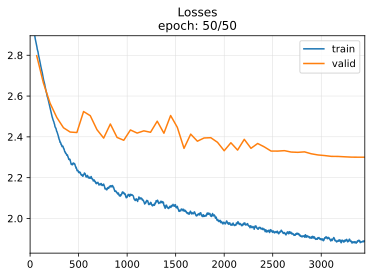

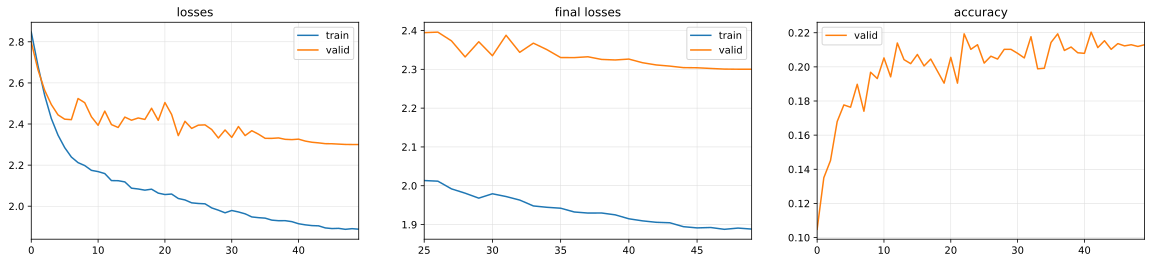

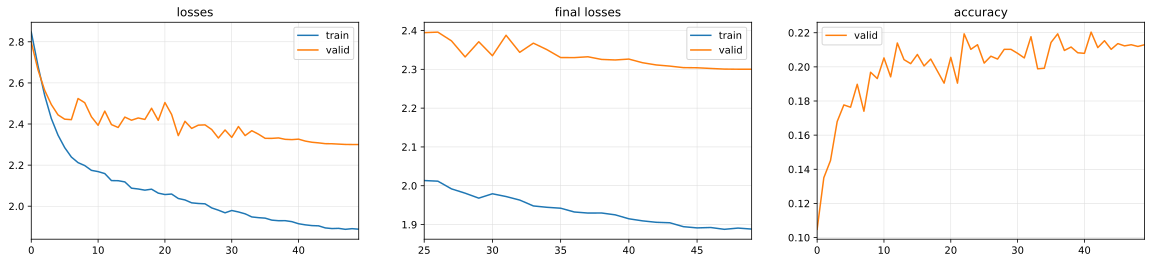

In [41]:
model = create_mlp_head(dls.vars, dls.c, dls.len)
model.apply(lin_zero_init)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraph())
learn.fit_one_cycle(50, lr_max=1e-4)
learn.plot_metrics()

## 其他方法

In [31]:
tfms = [None, [Categorize()]]
dsets = TSDatasets(tsai_X, tsai_y, tfms=tfms, splits=tsai_splite, inplace=True)

In [9]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)

In [17]:
archs = [
#          (FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), 
#          (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
#          (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
#          (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}),  # (mWDN, {'levels': 4}), 
#         (TCN, {}), (MLSTM_FCN, {}), (MLSTM_FCNPlus, {}), # (ROCKET, {}), 
#          (XceptionTimePlus, {}), # (TabModel, {}), 
#          (TST, {}), # (TabTransformer, {}),(MiniRocket, {}), 
#           (XCM,{}),
          (TCN, {}), (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':1, 'bidirectional': False}),   
          (XCMPlus, {}), (XCM,{}), (LSTM, {'n_layers':3, 'bidirectional': False}),(OmniScaleCNN, {})]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'train loss', 'valid loss', 'accuracy', 'time'])
for i, (arch, k) in enumerate(archs):
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(100, 1e-3)
    PATH = Path('./models/' + str(i) + model.__class__.__name__ + 'Classifier.pkl')
    learn.export(PATH)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

arch hyperparams  train loss  valid loss  accuracy time
0  XCMPlus          {}    1.612283    2.231205  0.237487  130

In [10]:
model = XceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('sEMGDL')

Path('models/sEMGDL.pth')

SuggestedLRs(valley=0.0010000000474974513)

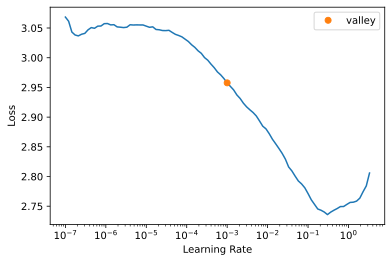

In [11]:
learn.load('sEMGDL')
learn.lr_find()

In [12]:
learn.fit_one_cycle(25, lr_max=0.0010000000474974513)
learn.save('sEMGDL_FIT')

Path('models/sEMGDL_FIT.pth')

X.shape: (2977, 1, 8)
y.shape: (2977,)
Selected metric: accuracy
Computing feature importance (permutation method)...


  0 feature: BASELINE             accuracy: 0.231105


  0 feature: var_0                accuracy: 0.046355



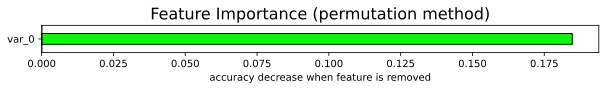

Feature  accuracy  accuracy_change
0     var_0  0.046355          0.18475
1  BASELINE  0.231105         -0.00000

In [13]:
learn.feature_importance()

X.shape: (2977, 1, 8)
y.shape: (2977,)
Selected metric: accuracy
Computing step importance...


  0 step: BASELINE             accuracy: 0.231105


  1 step: 0                    accuracy: 0.211287


  2 step: 1                    accuracy: 0.182398


  3 step: 2                    accuracy: 0.189117


  4 step: 3                    accuracy: 0.204232


  5 step: 4                    accuracy: 0.208599


  6 step: 5                    accuracy: 0.158549


  7 step: 6                    accuracy: 0.181391


  8 step: 7                    accuracy: 0.180719



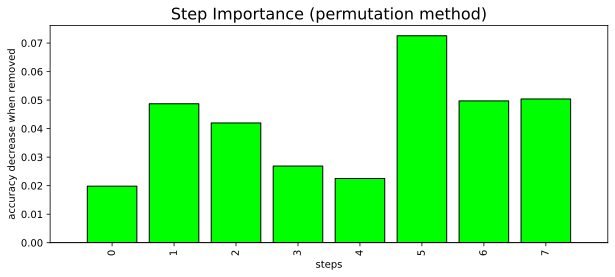

Step  accuracy  accuracy_change
0         5  0.158549         0.072556
1         7  0.180719         0.050386
2         6  0.181391         0.049714
3         1  0.182398         0.048707
4         2  0.189117         0.041989
5         3  0.204232         0.026873
6         4  0.208599         0.022506
7         0  0.211287         0.019819
8  BASELINE  0.231105        -0.000000

In [14]:
learn.step_importance()

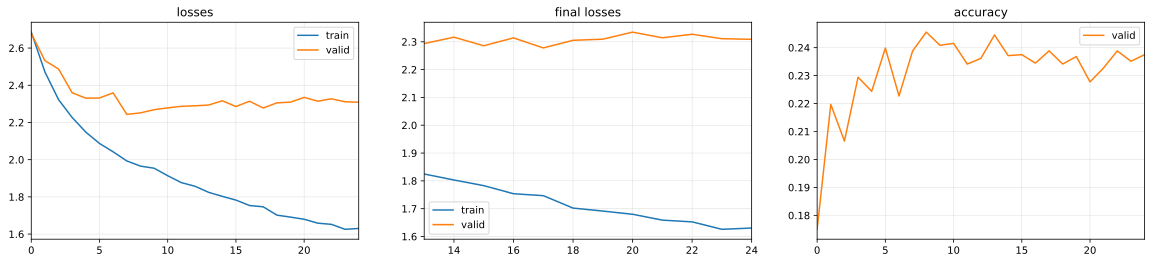

In [59]:
learn.recorder.plot_metrics()

In [65]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [66]:
del learn, dsets, dls

In [67]:
learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:128, vars:1, len:8, device=cuda:0),
 TensorCategory([ 4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,
          7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11,
         11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14,
         15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18,
         18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 19, 19, 19, 19, 19, 18, 18, 18,
         18, 18, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 14,
         14, 14, 14, 14, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 11, 11, 11, 11,
         11, 10], device='cuda:0'))

In [68]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds

(TensorBase([[0.0041, 0.0041, 0.0085,  ..., 0.0040, 0.0040, 0.0029],
         [0.0062, 0.0067, 0.0150,  ..., 0.0065, 0.0061, 0.0044],
         [0.0139, 0.0273, 0.0818,  ..., 0.0193, 0.0159, 0.0109],
         ...,
         [0.0066, 0.0061, 0.0126,  ..., 0.0061, 0.0064, 0.0059],
         [0.0106, 0.0079, 0.0142,  ..., 0.0078, 0.0090, 0.0078],
         [0.0072, 0.0063, 0.0021,  ..., 0.0023, 0.0026, 0.0020]]),
 TensorCategory([4, 4, 4,  ..., 6, 6, 6]),
 TensorBase([4, 4, 4,  ..., 5, 5, 5]))

In [69]:
(valid_targets == valid_preds).float().mean()

TensorCategory(0.2284)

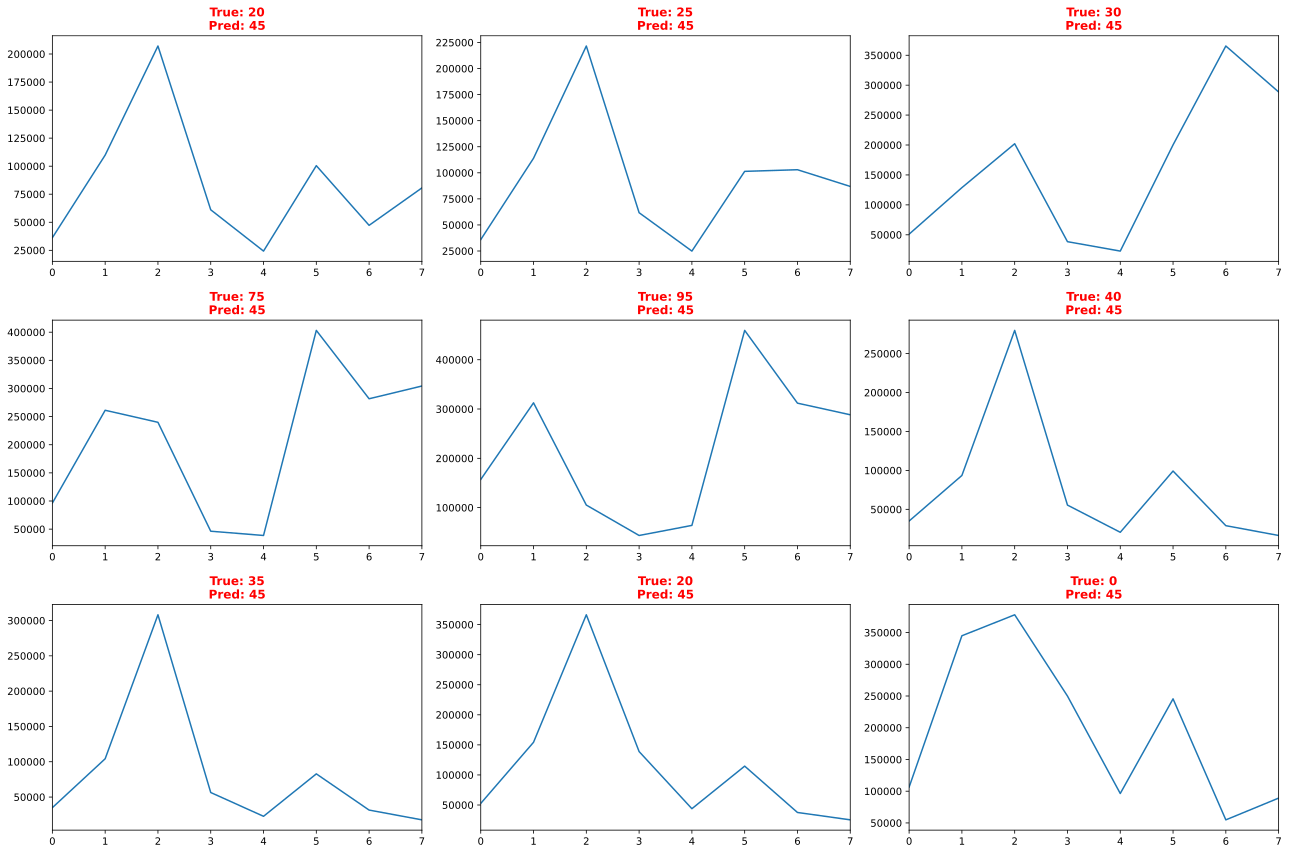

In [70]:
learn.show_results()

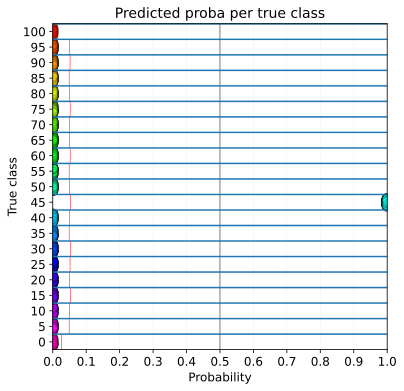

In [71]:
learn.show_probas()

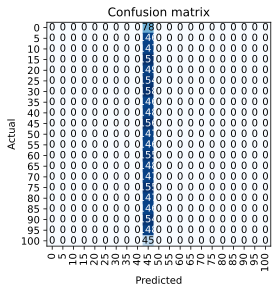

In [72]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [74]:
interp.most_confused(min_val=3)

[(30, 45, 158),
 (15, 45, 157),
 (60, 45, 155),
 (75, 45, 155),
 (25, 45, 154),
 (90, 45, 154),
 (20, 45, 149),
 (40, 45, 148),
 (65, 45, 148),
 (95, 45, 148),
 (10, 45, 147),
 (50, 45, 147),
 (70, 45, 147),
 (80, 45, 147),
 (5, 45, 146),
 (35, 45, 146),
 (55, 45, 146),
 (85, 45, 146),
 (0, 45, 78),
 (100, 45, 45)]

In [76]:
test_ds = valid_dl.dataset.add_test(tsai_X, tsai_y)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:128, vars:1, len:8, device=cuda:0),
 TensorCategory([ 4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,
          7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11,
         11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14,
         15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18,
         18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 19, 19, 19, 19, 19, 18, 18, 18,
         18, 18, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 14,
         14, 14, 14, 14, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 11, 11, 11, 11,
         11, 10], device='cuda:0'))

In [78]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(TensorBase([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 TensorCategory([4, 4, 4,  ..., 6, 6, 6]),
 TensorBase([9, 9, 9,  ..., 9, 9, 9]))

In [83]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')

accuracy:   0.051814


In [84]:
test_ds = dls.dataset.add_test(tsai_X)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:128, vars:1, len:8, device=cuda:0),)

In [85]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas

TensorBase([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

# tsai回归处理

arch: TSTPlus(c_in=1 c_out=1 seq_len=8 device=cuda:0, arch_config={}, kwargs={})


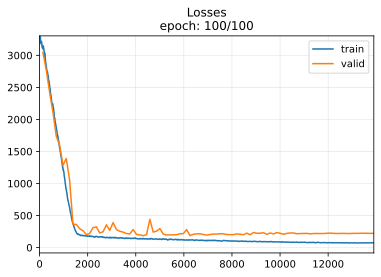

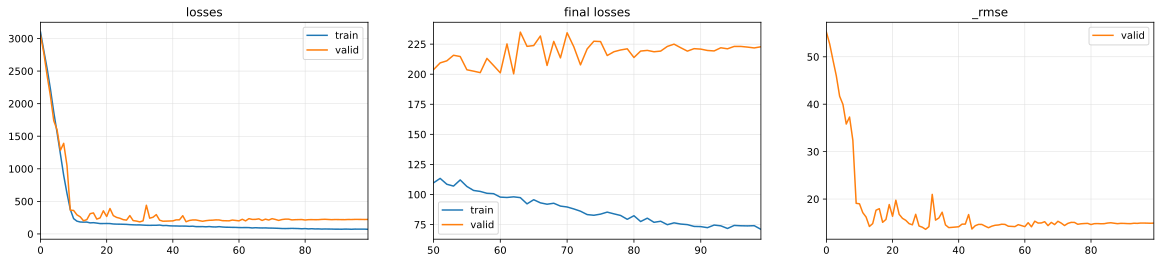

In [8]:
batch_tfms = TSStandardize(by_sample=True)
reg = TSRegressor(tsai_X, tsai_y, splits=tsai_splite, path='models', arch=TSTPlus, batch_tfms=batch_tfms, metrics=rmse, cbs=ShowGraph(), verbose=True)
reg.fit_one_cycle(100, 3e-4)
reg.export("reg.pkl")

In [9]:
check_data(tsai_X, tsai_y, tsai_splite)

X      - shape: [11908 samples x 1 features x 8 timesteps]  type: ndarray  dtype:float32  isnan: 0
y      - shape: (11908,)  type: ndarray  dtype:int32  isnan: 0
splits - n_splits: 2 shape: [8931, 2977]  overlap: False


In [10]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(tsai_X, tsai_y, splits=tsai_splite, tfms=tfms, batch_tfms=batch_tfms, bs=128)
dls.one_batch()

(TSTensor(samples:128, vars:1, len:8, device=cuda:0),
 tensor([76., 96., 39., 60., 83., 91., 29.,  5., 74., 94., 65., 56., 59., 73.,
         95., 36., 17., 43., 56., 87., 63.,  3., 55., 64., 42., 47., 78., 91.,
         44., 75., 76., 16., 60., 66.,  9., 91., 78., 57., 25., 80., 21., 68.,
         22., 31.,  2.,  0., 19., 20., 64., 89., 97., 70., 18.,  4., 15., 52.,
         73., 81., 75., 23.,  1., 34., 73., 67.,  4., 56., 97., 84., 32., 94.,
         96., 74., 71., 14., 84., 58.,  1., 19., 53., 53., 61., 40.,  5., 20.,
         43., 87., 98., 84., 74., 65., 51., 61., 92., 84., 51., 17., 94., 35.,
         66., 57., 44., 74., 88., 78., 96.,  4., 84., 18., 13., 86., 37., 91.,
         95., 25.,  8., 35., 86., 96., 15., 94., 69., 82., 41., 24., 32., 55.,
         67., 43.], device='cuda:0'))

In [11]:
dls.c

1

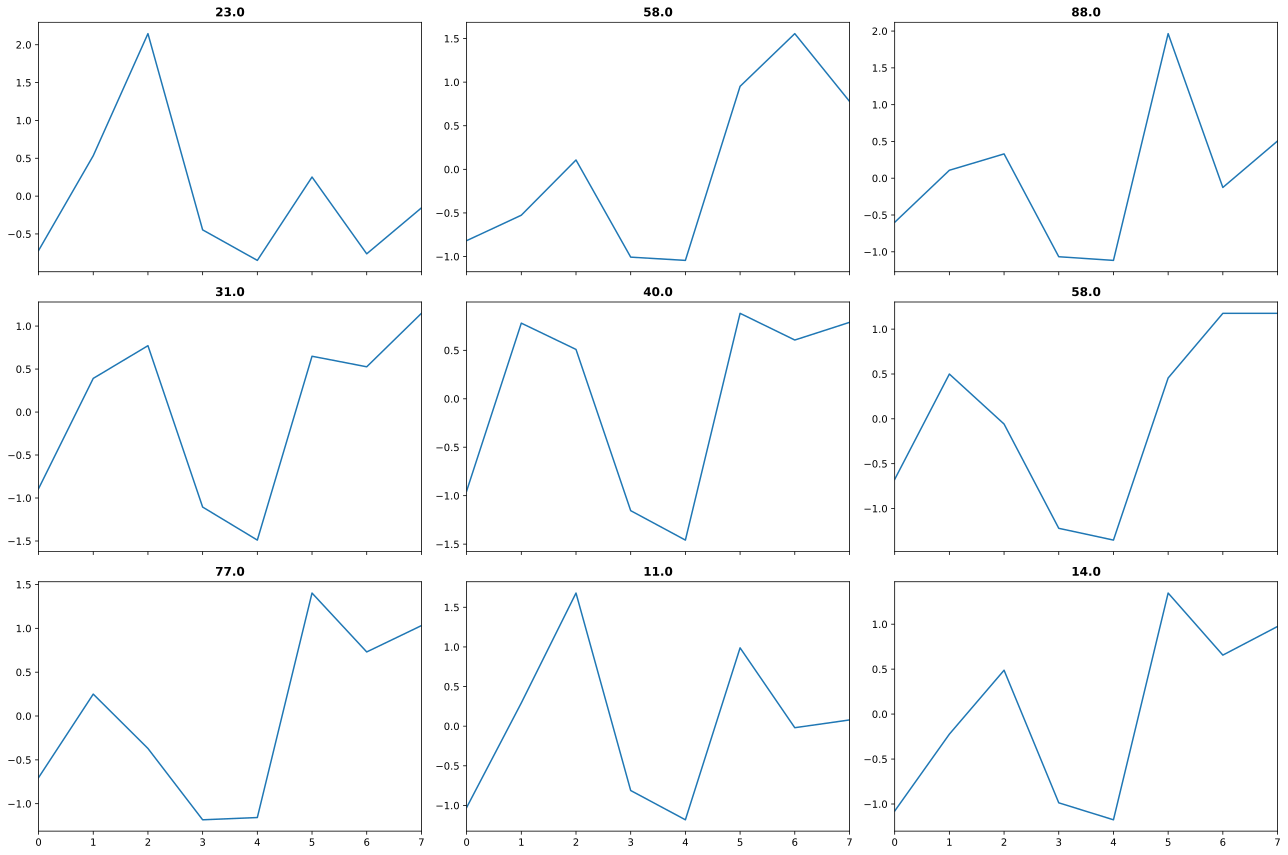

In [12]:
dls.show_batch()

SuggestedLRs(valley=0.009120108559727669)

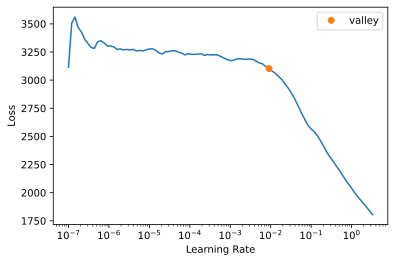

In [13]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.lr_find()

In [14]:
learn.loss_func

FlattenedLoss of MSELoss()

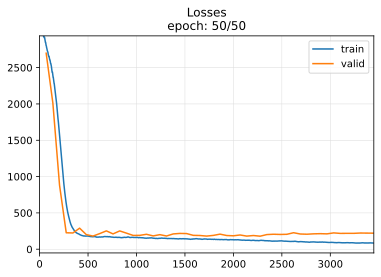

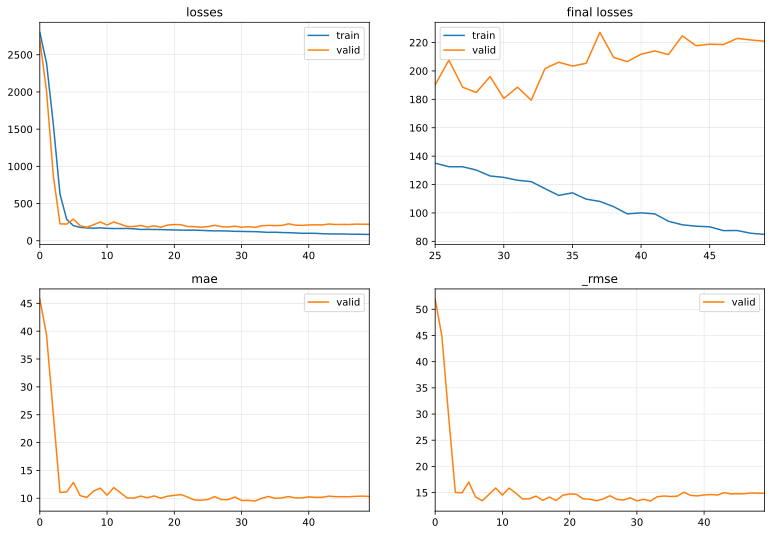

In [15]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.fit_one_cycle(50, 1e-2)

In [16]:
PATH = Path('./models/Regression.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

In [17]:
del learn

In [18]:
PATH = Path('./models/Regression.pkl')
learn = load_learner(PATH, cpu=False)

In [19]:
valid_features = valid_features.reshape(-1, 1, 8)
valid_labels = valid_labels.reshape(-1)

In [20]:
probas, _, preds = learn.get_X_preds(tsai_X)
skm.mean_squared_error(tsai_y, preds, squared=False)

Could not do one pass in your dataloader, there is something wrong in it


10.753861511008584

In [22]:
archs = [
#          (FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), 
#          (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
#          (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
#          (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}),  # (mWDN, {'levels': 4}), 
#         (TCN, {}), (MLSTM_FCN, {}), (MLSTM_FCNPlus, {}), (XceptionTimePlus, {}), 
          (TST, {}),  (XCM,{}), (XCMPlus, {})]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'train loss', 'valid loss', 'mae', 'rmse' , 'time'])
for i, (arch, k) in enumerate(archs):
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    learn = ts_learner(dls, model, metrics=[mae, rmse])
    start = time.time()
    learn.fit_one_cycle(100, 1e-3)
    PATH = Path('./models/' + str(i) + model.__class__.__name__ + 'Regression.pkl')
    learn.export(PATH)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, vals[0], vals[1], vals[2], vals[3], int(elapsed)]
    results.sort_values(by='rmse', ascending=True, ignore_index=True, inplace=True)
    clear_output()
    display(results)

arch hyperparams  train loss  valid loss       mae       rmse time
0      XCM          {}   80.587944  142.907852  8.761258  11.954407   70
1  XCMPlus          {}   80.774742  145.046341  8.849000  12.043519   71
2      TST          {}   79.064278  159.413147  9.367193  12.625893  145

In [ ]:
valid_features = valid_features.reshape(-1, 1, 8)

In [ ]:
archs = [
         (FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), 
         (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
         (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
         (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}),  # (mWDN, {'levels': 4}), 
        (TCN, {}), (MLSTM_FCN, {}), (MLSTM_FCNPlus, {}), (XceptionTimePlus, {}),  (TST, {}), (XCM,{}), (XCMPlus, {})]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'rmse'])
for i, (arch, k) in enumerate(archs):
    PATH = Path('./models/' + str(i) + model.__class__.__name__ + 'Regression.pkl')
    learn = load_learner(PATH, cpu=False)
    probas, _, preds = learn.get_X_preds(valid_features)
    results.loc[i] = [arch.__name__, k, skm.mean_squared_error(valid_features, preds, squared=False)]
    results.sort_values(by='score', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

# 模型建立

In [11]:
# Encoder Decoder Architecture + ResNet

class HbConNet(nn.Module):
    def __init__(self):
        super(HbConNetb, self).__init__()
        
        
    
    def forward(self, x):
        
        return x


    